# Solution to the Ising simulation assignments


## The slow update scheme: Assignment \# 1
We are going to construct a MCMC for an Ising model on a d-dimensional rectangular lattice with periodic boundary conditions. We will progress step-by-step. We first implement a *slow* version computing explicitely the energy of the Ising model with a function
```
energy(x::Lattice, h::Vector{Float64}, spin::Vector{Int})
```
The energy should return the value of the energy:
$$
H(\vec s) =  -\sum_{i=1}^N \left( \frac12 \sum_{j\in\partial_i} s_j + h_i\right)s_i
$$
where with the symbol $\partial_i$ we indicate the 2d set of neighbors of site $i$.

Defining `nsweep` a set of `N` elementary Monte Carlo steps (i.e. MC trials accepted or not), verify that the magnetization in a $(30\times 30)$ lattice with $h_i=0$ (no external fields)
$$
M := \frac1N \sum_{i=1}^N s_i 
$$
at inverse temperature $\beta=0.5$ after ~ 500 sweeps, ends fluctuating around a value 0.911319377877496.

In general we have that, from the exact Onsager solution valid at $d=2$ for h=0 

$$
M(\beta) = \left[ 1- \left(\frac{1}{\sinh(2\beta)}\right)^4\right]^{1/8}\quad,\quad \beta > \beta_c=\frac {\ln (1+\sqrt{2})}{2}
$$

## Solution to the Assignment \# 1

We first define a function computing the energy of an Ising configuration. 
All the function called are found in the file `simplemc.jl`.

We will call it `energyslow`, as it will be later on changed in favor of a more
efficient solution. We are going to use the `Lattice` structure defined in `lattice.jl`.

In [1]:
using Revise, LinearAlgebra, Random, Statistics, PyPlot
include("lattice.jl")
includet("mc.jl")
includet("simplemc.jl")

In [2]:
function energyslow(x, h, spin)
    e = 0.0
    @inbounds for i in eachindex(spin)
        sumj = 0
        @simd for j in x.neig[i]
            sumj += spin[j]
        end
        e += (0.5 * sumj + h[i]) * spin[i]
    end
    return -e
end

energyslow (generic function with 2 methods)

In [3]:
dims=(30,30)
N = prod(dims)
h = zeros(prod(dims))
s0 =  ones(Int, prod(dims)) # all positive spins configuration
β = 0.5 
Λ = Lattice(dims);

Let's see if for a configuration of all spins up (+1) and zero external field
`h` we get the sought energy which in 2 dimension is -2N.

In [4]:
energyslow(Λ,h,s0)==-2N

true

We now write our first monte-carlo version by defining:
1. `one_mc_sweep!`: call `N` times the functio `one_mc_step`.
2. `one_mc_step!`: makes an elementary mc step attempt.

Now let us compute a trajectory of the system;

In [6]:
h = zeros(prod(dims))
nsweeps=1000
res=mcmcslow(dims,nsweeps,β,h);

We can now plot the magnetization as a function of the iteration time. Recalling
that the system in the absence of an external field `h` is symmetric for spin
flip, i.e. $P(\vec s)=P(-\vec s)$, we better consider the absolute value of the
magnetization. 

As stated in the assignent, for the 2-D Ising ferromagnet at 0 external field, we have an analytic solution
for the magnetization.

In [7]:
magn2d(x) = x >= log(1 + √2) / 2 ? (1 - (1 / sinh(2x))^4)^(1 / 8) : 0.0 # is zero for x <= βc2d
βc2d = log(1+√2)/2;

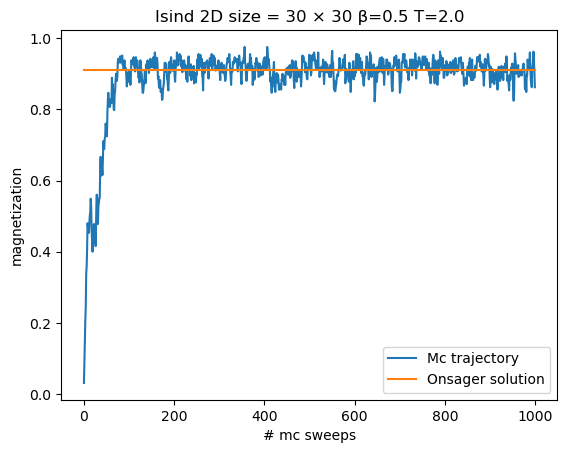

In [8]:
close("all")
title("Isind 2D size = $(Λ.dims[1]) × $(Λ.dims[2]) β=$β T=$(1/β)")
plot(abs.(mean(res, dims = 1)) |> vec)
plot(magn2d(β)*ones(size(res,2)))
xlabel("# mc sweeps")
ylabel("magnetization")
legend(["Mc trajectory","Onsager solution"])
gcf()

We can see how the magnetization after ~ 200 mcsweeps nicely fluctuates around
the theoretical solution.

## Assignment #2: Structured code

We are going now to put together all different pieces to have a flexible program. The method combining the different pieces will be defined by the following function
```
function mcising(I::NTuple{N,Int},β::T;  # linear size of the lattice + temperature
                 h::Vector{T}=T[], # external field
                 x0::Vector{Int}=rand([-1,1],prod(I)), # initial configuration 
                 nterm::Int=100,  # number of mcsweeps for thermalization
                 nmeas::Int=1000, # number of measurments
                 nsweep::Int=100, # number of mcsweeps between measurements
                 verbose::Bool=false) where {T<:Real,N}
```

The body of the program should be something like

```
for t in 1:nterm   # thermalization
    onemcsweep!(ising)
end

for n in 1:nmeas # loop for measurements   
    for t in 1:nsweep # number of mcsweeps between measurements
      onemcsweep!(ising)
    end
    measures!(output,ising)
end
```
where we we define a `struct` in which we will store our measurements:

```
mutable struct Measures{T<:AbstractFloat}
    it::Int # it contains the iteration step 
    β::T    # the inverse temperature
    ene::Vector{T}  # a vector of length nmeas containing the energy measured at time it 
    mag::Vector{T}  # a vector of length nmeas containing the magnetization measured at time it 
    conf::Vector{BitArray{1}} # a vector of length nmeas containing the spin configuration measured at time it 
end
```

We encode the spin configuration into a `BitArray{1}` using the following constructor. If `x` is an instance of type `Ising`, we can compute a Bool representation of the configuration as

```
BitArray(map(spin2bool,x.spin))
```
where 
```
spin2bool = x -> x > 0
```



## Solution to Assignment #2

The solution of this assignement is contained in the file `mc.jl`

## Solution of the "simple" ising mcmc

In [9]:
resfast=mcising(dims,β,h=zeros(prod(dims)),nterm=0,nmeas=300,nsweep=1);

We can show that the two programs show analogous phenomenology.

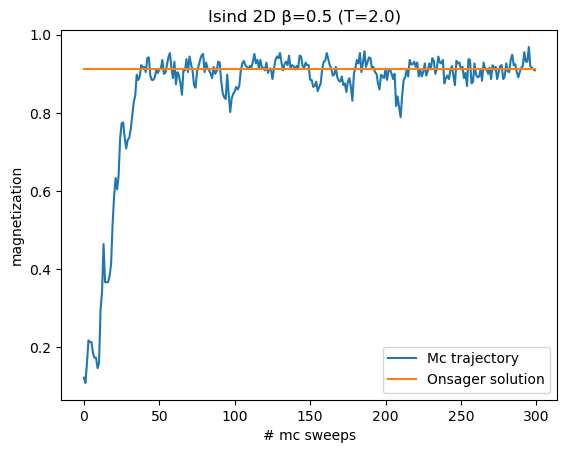

In [10]:
close("all")
title("Isind 2D β=$β (T=$(1/β))  ")
plot(abs.(resfast.mag))
plot(magn2d(β)*ones(length(resfast.mag)))
xlabel("# mc sweeps")
ylabel("magnetization")
legend(["Mc trajectory","Onsager solution"])
gcf()

We can see how much faster is the fast version compared to the slow one.

In [11]:
tslow = @elapsed res = mcmcslow(dims, nsweeps, β, h);
tfast = @elapsed resfast = mcising(dims, β, h = zeros(prod(dims)), nterm = 0, nmeas = 300, nsweep = 1);
(tfast = tfast, tslow = tslow, ratio = tslow / tfast)

(tfast = 0.005045156, tslow = 6.437431935, ratio = 1275.9629107603412)

In [12]:
dims=(50,50)
tslow = @elapsed res = mcmcslow(dims, nsweeps, β, h);
tfast = @elapsed resfast = mcising(dims, β, h = zeros(prod(dims)), nterm = 0, nmeas = 300, nsweep = 1);
(tfast = tfast, tslow = tslow, ratio = tslow / tfast)

(tfast = 0.01421359, tslow = 78.805488284, ratio = 5544.376071351432)

Interestingly, the new version is ~ 250 times faster for a 900 spin system, and
(~ 1000 times for a 2500 spin system) than the slow one. 

This might change on your computer, as this measure it's strongly hardware dependent.

## Assgnement #3: Establishing the thermalization time

A practical concern is how to establish the thermalization time. To do so we perform a logarithmic block division of data.
Suppose we have `nmeas` data. We divide the data into blocks in the following way:
* block 1 - data from nmeas/2 + 1 to nmeas
* block 2 - data from nmeas/4 + 1 to nmeas/2
* block 3 - data from nmeas/8 + 1 to nmeas/4
* .... until there is at least 1 datum

Write a function 

```
function blockmean(data::AbstractArray)
```
which perform the mean over the blocks and returns three vectors: $t, \mu, \sigma$ of length nblocks containing:
1. the time at which the measurement has been performed (taken as the midpoint of the block)
2. the value of the mean of the data on the block
3. the std of the mean on computed on the block

The solution of this assignment is contained in file `blockmean.jl`.

In [13]:
include("blockmean.jl")

blockmean (generic function with 1 method)

In [14]:
nsamples=100
dims=(30,30)
resterm=[mcising(dims,β,h=zeros(prod(dims)),nterm=0,nmeas=2048,nsweep=1) for _ in 1:nsamples];

In [15]:
tm,μm,σm = blockmean(resterm, field=:mag);
te,μe,σe = blockmean(resterm, field=:ene);

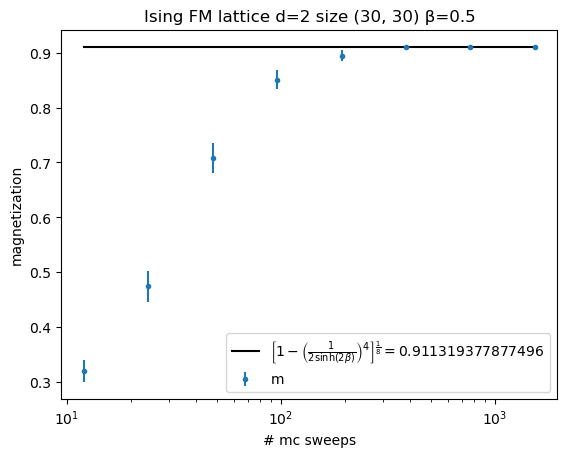

In [16]:
close("all")
meq = magn2d(β)
errorbar(tm, μm, σm, fmt=".")
plot(tm,ones(length(tm))*meq,"-k")
plt.xscale(:log)
plt.xlabel("# mc sweeps")
plt.ylabel("magnetization")
plt.title("Ising FM lattice d=$(length(dims)) size $dims β=$β")
plt.legend([L"\left[1-\left(\frac{1}{2\sinh(2\beta)}\right)^4\right]^{\frac{1}{8}}="*"$meq","m"])
gcf()

For the energy we need a bit more of work as the theoretical estimate cannot be
computed analytically as it involves nasty integrals.

To run the following part, the packages `ForwardDiff` and `QuadGK` are must be installed.

In [17]:
using ForwardDiff, QuadGK
function fe_density2d(β, θ)
    k = 2sinh(2β) / cosh(2β)^2
    return log(1 + sqrt(1 - k^2 * cos(θ)^2))
end

function free_energy2d(β)
    f(θ) = fe_density2d(β, θ)
    res = QuadGK.quadgk(f, 0, π)
    return -log(2) / 2 - log(cosh(2β)) - res[1] / (2π)
end
average_energy2d(b) = ForwardDiff.derivative(free_energy2d, b);
#specific_heat2d(b) = -b^2 * ForwardDiff.derivative(average_energy2d, b)


average_energy2d (generic function with 1 method)

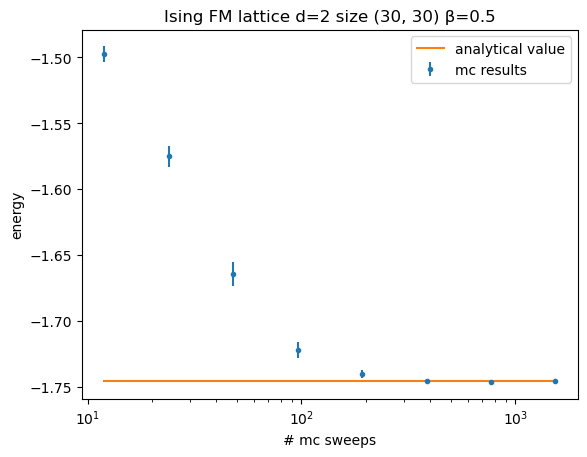

In [18]:
close("all")
errorbar(te, μe / prod(dims), σe / prod(dims), fmt = ".") # note that we consider the energy density E/N
plot(te, ones(length(te)) * average_energy2d(β)) 
plt.xscale(:log)
plt.yscale(:linear)
plt.title("Ising FM lattice d=$(length(dims)) size $dims β=$β")
plt.xlabel("# mc sweeps")
plt.ylabel("energy")
plt.legend(["analytical value","mc results"])
gcf()

Both for the energy and for the magnetization, the equilibration time is ~
$10^3$ mc sweeps.

## Assgnement #4: Establishing the autocorrelation time

Write a 
```
function autocorrelation(vecoutput::Vector{Measures{T}},Δt::Int; field::Symbol=:mag) where T<:AbstractFloat
```
where:
* `vecoutput::Vector{Measures{T}}` is a vector of `Measures`.
* `Δt::Int` is the the maximal time interval over which we compute autocorrelations.
* `field::Symbol` specify over which observable we compute the autocorrelations. Allowed 
   values are: `:mag,:ene,:conf` (`:mag` being the default)
   

How we compute the autocorrelation for the magnetization? For each trajectory in the `Measures` struct we store the values of the observable. Let us consider energy, and magnetisation defined as:

$$
m(t) = \frac 1N\sum_{i=1}^N s_i(t)
$$
$$
E(t) = \frac12 \sum_{i=1}^N  \sum_{j\in\partial_i}s_i(t)s_j(t)
$$

From the above quantities, compute the equilibrium auto-correlation function $C_A(\Delta t)$ defined as:

$$
C_A(\Delta T) = \frac{1}{T_\mathrm{meas} -\Delta t}\sum_{t=1}^{T_\mathrm{meas} -\Delta t} A(t)A(t+\Delta t) - 
\left( \frac{1}{T_\mathrm{meas}-\Delta t}\sum_{t=1}^{T_\mathrm{meas}-\Delta t }A(t)\right)
\left( \frac{1}{T_\mathrm{meas}-\Delta t}\sum_{t=1}^{T_\mathrm{meas} -\Delta t} A(t+\Delta T)\right)
$$

where the observable $A$ is either the magnetization $m$, or the energy $E$. Study the profile of the autocorrelation function as a function of the time interval $\Delta t$. As an example, we show below the profile of the equilibrium autocorrelation of the magnetization as a function of $\Delta T$.



## Solution to Assignment #4


The solution of this assignment is contained in the file `autocorrelation.jl`

*WARNING!!!* For this assignemnt I do not provide the solution.

In [19]:
include("autcorrelation.jl")

In [20]:
nsamples=100
resautocorr=[mcising(dims,β,h=zeros(prod(dims)),nterm=5000,nmeas=50,nsweep=1) for _ in 1:nsamples];

In [21]:
μmag,σmag=autocorrelation(resautocorr,49,field=:mag);
μene,σene=autocorrelation(resautocorr,49,field=:ene);

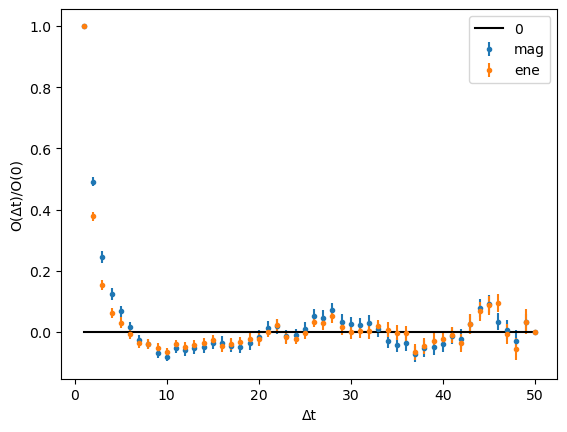

In [22]:
close("all")
plot(1:length(μene), zeros(length(μene)), "-k")
errorbar(1:length(μmag), μmag, σmag, fmt = ".")
errorbar(1:length(μene), μene, σene, fmt = ".")

#errorbar(1:length(μspin),μspin,σspin,fmt=".")
plt.xscale(:linear)
plt.yscale(:linear)
plt.xlabel("Δt")
plt.ylabel("O(Δt)/O(0)")
#plt.legend(["mag","ene","spin"])
plt.legend(["0", "mag", "ene"])
# plt.xlim(1,10)
# plt.ylim(1e-4,1)
gcf()


Note that, as costomary with many auto-correlation observables, we plot the
ratio of $\frac{C_A(\Delta T)}{C_A(0)}$, *i.e.* the time autocorrelation divided
the initial variance at $\Delta T=0$ the observable $A$.

As you can see the behaviour is non trivial, as the system becomes mildely
negatively correlated  in a time window $
\Delta T \in [7,25]$.

However, we can safely assume that for any $\Delta T> 30$, the system is decorrelated.